# Imports

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm, zscore, pearsonr, spearmanr
import statsmodels.api as sm

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
import joblib

from statsmodels.tsa.api import VAR
from dtaidistance import dtw
from statsmodels.tsa.stattools import grangercausalitytests


import geopandas as gpd
from shapely.geometry import Point

# Load and Format

In [2]:
df = pd.read_csv('data.csv')
df = df.set_index('datetime')
df

,02t,03t,11t,12t,50t,52t,53t,54t,59t,61t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-19 01:00:00,55.5,51.7,47.1,44.2,50.1,54.5,49.9,44.9,36.9,41.1,...,62.1,55.7,54.1,50.1,66.9,65.2,48.2,52.7,51.0,49.6
2025-01-19 02:00:00,60.3,56.6,48.1,48.1,54.0,60.7,55.5,55.1,37.4,47.4,...,63.8,45.9,55.0,52.6,63.1,64.1,51.5,55.2,52.0,54.7
2025-01-19 03:00:00,57.9,58.1,46.2,45.8,55.3,56.0,56.7,46.8,40.9,44.9,...,69.8,40.5,47.3,54.4,68.0,78.9,56.4,58.8,49.0,56.9
2025-01-19 04:00:00,55.2,55.3,40.3,43.1,48.6,55.1,45.5,40.5,45.2,40.1,...,77.6,43.4,45.2,53.2,69.1,73.7,50.8,60.2,45.0,56.1
2025-01-19 05:00:00,60.7,60.3,40.9,44.5,47.9,58.4,45.1,41.4,47.2,41.1,...,92.0,50.8,53.1,70.5,72.0,74.6,49.1,76.5,41.0,48.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10 11:00:00,34.3,43.9,35.1,35.4,39.2,34.7,39.1,52.3,33.9,34.9,...,41.5,32.4,31.3,30.0,45.2,31.7,36.1,28.3,34.0,42.9
2025-03-10 12:00:00,26.2,35.8,29.1,30.3,35.1,27.1,32.7,45.1,30.5,30.9,...,32.4,29.4,28.3,27.7,27.4,21.9,29.7,28.9,27.0,30.0
2025-03-10 13:00:00,28.4,31.6,28.5,28.1,33.1,29.9,31.2,42.7,27.6,28.1,...,30.0,32.0,27.4,36.8,31.9,28.2,29.9,27.7,30.0,31.8


In [3]:
# old_df = pd.read_csv('data.csv')
# new_df = pd.read_csv('new_data.csv')
# df = pd.concat([old_df,new_df])
# df = df.set_index('datetime')
# df

# Preprocessing

In [4]:
df.describe()

,02t,03t,11t,12t,50t,52t,53t,54t,59t,61t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
count,1211.000000,1212.000000,1215.000000,1215.000000,1212.000000,1209.000000,1213.000000,1215.000000,1215.000000,1207.000000,...,1212.00000,1187.000000,1214.000000,1211.000000,1212.000000,1213.000000,1215.000000,1214.000000,1208.000000,1211.000000
mean,40.958216,40.663201,35.114486,35.203457,39.642987,40.559388,39.061006,42.058848,29.713416,34.683513,...,44.67302,36.804044,35.636820,37.392238,45.605693,38.983430,42.841893,40.482784,37.648427,40.601817
std,19.073293,20.163197,15.409927,15.464452,17.221875,19.144439,17.521126,17.561955,13.750811,15.227800,...,22.18481,17.203038,16.503243,21.157558,51.620549,22.435422,57.910087,19.901996,18.568685,18.142552
min,11.100000,9.300000,10.200000,10.500000,14.100000,10.900000,13.100000,13.800000,4.400000,10.600000,...,4.60000,10.600000,11.200000,0.800000,0.400000,0.100000,8.500000,4.600000,7.000000,6.100000
25%,26.000000,24.700000,22.700000,22.500000,26.100000,25.400000,25.400000,28.200000,18.550000,22.100000,...,28.07500,26.200000,21.900000,21.800000,27.350000,22.800000,23.900000,25.600000,24.000000,27.000000
50%,38.100000,37.100000,32.500000,32.600000,36.900000,37.800000,35.800000,39.100000,27.800000,31.900000,...,41.45000,33.800000,32.650000,33.600000,39.100000,34.200000,36.500000,36.900000,35.000000,37.600000
75%,50.200000,50.800000,45.000000,44.450000,48.600000,49.800000,48.700000,52.050000,38.400000,44.100000,...,55.10000,42.400000,45.475000,47.200000,53.925000,49.200000,50.500000,49.700000,46.300000,50.400000
max,122.300000,117.300000,94.700000,91.700000,121.500000,117.000000,117.300000,112.500000,75.800000,93.300000,...,144.00000,190.000000,98.000000,145.600000,984.100000,143.400000,985.000000,127.100000,121.900000,125.400000


## handle NaN

In [5]:
def fill_missing_rows(df, freq='H'):
    """
    Fills missing rows in a DataFrame by adding missing time intervals and filling values using interpolation.
    
    :param df: The input DataFrame with missing rows
    :param freq: The frequency of the time intervals, default is 'H' for hourly. Can be 'D' for daily, etc.
    :return: A DataFrame with missing rows filled
    """
    # Ensure that the index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Generate a complete time range from the first to the last timestamp
    complete_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    
    # Reindex the dataframe with the complete time range
    df_reindexed = df.reindex(complete_time_range, method=None)
    
    # Interpolate missing values only in the rows with NaN (to avoid modifying existing data)
    df_reindexed = df_reindexed.interpolate(method='linear', limit_direction='both', axis=0)

    # Reset the index to the datetime index
    df_reindexed.index.name = 'datetime'

    return df_reindexed

In [6]:
df = fill_missing_rows(df)
df

,02t,03t,11t,12t,50t,52t,53t,54t,59t,61t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-19 00:00:00,63.8,58.4,52.2,52.7,55.9,62.2,54.6,55.9,46.9,52.5,...,66.9,68.8,55.9,49.9,74.2,64.0,55.1,64.8,63.0,65.0
2025-01-19 01:00:00,55.5,51.7,47.1,44.2,50.1,54.5,49.9,44.9,36.9,41.1,...,62.1,55.7,54.1,50.1,66.9,65.2,48.2,52.7,51.0,49.6
2025-01-19 02:00:00,60.3,56.6,48.1,48.1,54.0,60.7,55.5,55.1,37.4,47.4,...,63.8,45.9,55.0,52.6,63.1,64.1,51.5,55.2,52.0,54.7
2025-01-19 03:00:00,57.9,58.1,46.2,45.8,55.3,56.0,56.7,46.8,40.9,44.9,...,69.8,40.5,47.3,54.4,68.0,78.9,56.4,58.8,49.0,56.9
2025-01-19 04:00:00,55.2,55.3,40.3,43.1,48.6,55.1,45.5,40.5,45.2,40.1,...,77.6,43.4,45.2,53.2,69.1,73.7,50.8,60.2,45.0,56.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10 11:00:00,34.3,43.9,35.1,35.4,39.2,34.7,39.1,52.3,33.9,34.9,...,41.5,32.4,31.3,30.0,45.2,31.7,36.1,28.3,34.0,42.9
2025-03-10 12:00:00,26.2,35.8,29.1,30.3,35.1,27.1,32.7,45.1,30.5,30.9,...,32.4,29.4,28.3,27.7,27.4,21.9,29.7,28.9,27.0,30.0
2025-03-10 13:00:00,28.4,31.6,28.5,28.1,33.1,29.9,31.2,42.7,27.6,28.1,...,30.0,32.0,27.4,36.8,31.9,28.2,29.9,27.7,30.0,31.8


In [7]:
df.isna().sum().sum()

0

In [8]:
while True:
    nan = df.isna().sum().sum()
    print(f"NaN count: {nan}")
    if nan == 0:
        break
    # use median to be more robust against outliers
    df.fillna(df.rolling(window=24, min_periods=1).median(), inplace=True) 

NaN count: 0


## handle outliers

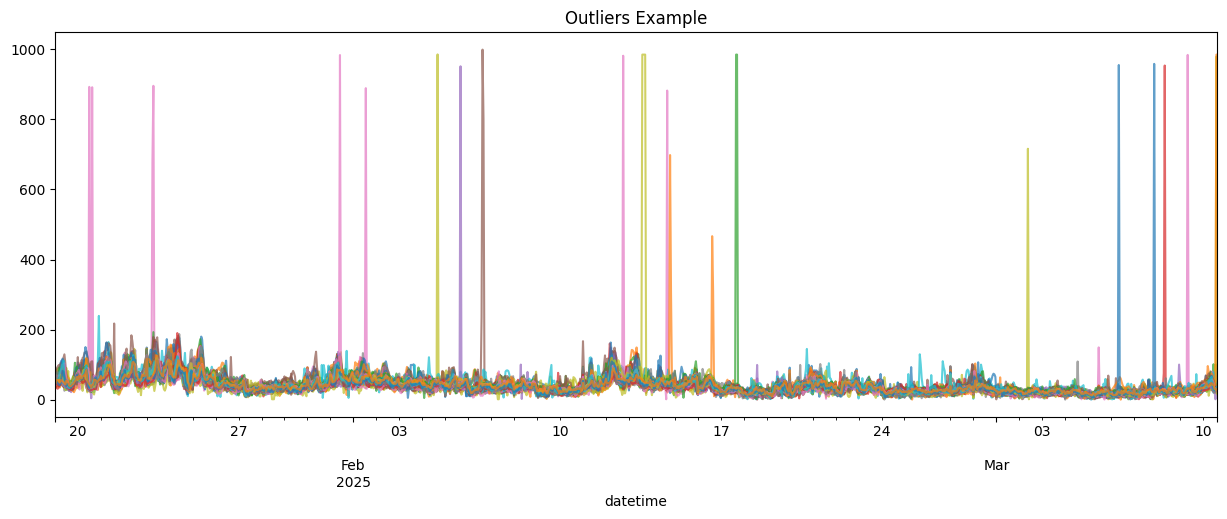

In [9]:
# some sensors' readings are outliers
df.plot(figsize=(15,5), alpha=0.7)
plt.title("Outliers Example")
plt.legend([], [], frameon=False)
plt.show()

In [10]:
z_scores = np.abs(df.apply(zscore))
z_scores.describe()

,02t,03t,11t,12t,50t,52t,53t,54t,59t,61t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,...,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,0.776724,0.780798,0.800179,0.797869,0.774758,0.773783,0.781043,0.799182,0.822529,0.806071,...,0.761774,0.669777,0.802797,0.749856,0.381406,0.760648,0.338374,0.755759,0.771688,0.776844
std,0.630101,0.625041,0.600009,0.603079,0.632518,0.633712,0.624734,0.601336,0.568957,0.592063,...,0.648109,0.742868,0.596498,0.661873,0.924788,0.649431,0.941399,0.655119,0.636263,0.629952
min,0.001462,0.000921,0.000927,0.000075,0.002066,0.007589,0.002085,0.002585,0.000664,0.000476,...,0.002125,0.000960,0.001347,0.001688,0.001370,0.002087,0.000619,0.002083,0.017798,0.002568
25%,0.295596,0.333636,0.351639,0.330117,0.317854,0.288341,0.335181,0.371702,0.400614,0.355836,...,0.264142,0.229190,0.328167,0.282380,0.136142,0.317766,0.119866,0.272342,0.305457,0.343470
50%,0.715788,0.711044,0.739465,0.737667,0.692191,0.702473,0.712462,0.726309,0.743006,0.757260,...,0.647645,0.514478,0.759433,0.640841,0.284728,0.637905,0.266766,0.630605,0.682588,0.684371
75%,1.057194,1.018929,1.072547,1.074330,1.051795,1.058688,1.044012,1.062660,1.143288,1.079716,...,1.026897,0.866316,1.086927,0.992550,0.474926,1.016035,0.398111,1.013262,1.059718,1.036360
max,4.273988,3.807920,3.869894,3.656426,4.761837,3.991246,4.472291,4.014411,3.354427,3.855833,...,4.484911,8.742184,3.783022,5.124378,18.215012,4.659238,16.282718,4.332072,4.537976,4.659721


In [11]:
df[z_scores > 3.75] = np.nan
while True:
    nan = df.isna().sum().sum()
    print(f"NaN count: {nan}")
    if nan == 0:
        break
    # use Max to fill NaN
    df.fillna(df.rolling(window=24, min_periods=1).max(), inplace=True) 

NaN count: 507
NaN count: 0


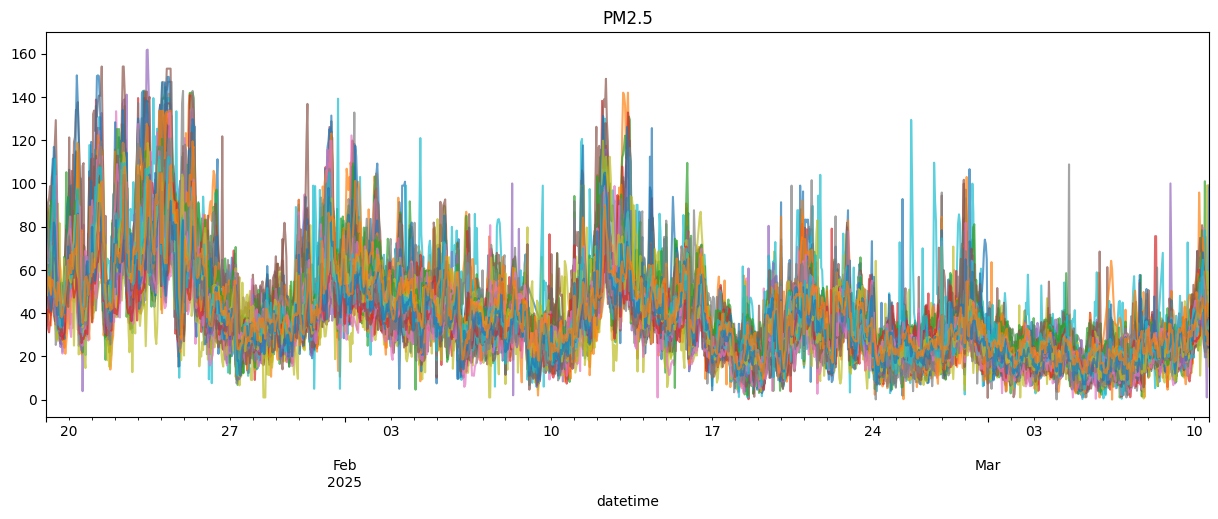

In [12]:
df.plot(figsize=(15,5), alpha=0.7)
plt.title("PM2.5")
plt.legend([], [], frameon=False)
plt.show()

In [13]:
df.to_csv('cleaned_data.csv')

# EDA

In [14]:
def plot_average_over_time(df, title="Average Value Over Time", ylabel="Average Value", xlabel="Time"):
    """
    Plot the average value across columns over time.

    Parameters:
    - df (DataFrame): The input DataFrame with timestamps as the index.
    - title (str): Title of the plot.
    - ylabel (str): Label for the y-axis.
    - xlabel (str): Label for the x-axis.

    Returns:
    - None: Shows the plot directly.
    """
    average_series = df.mean(axis=1)

    plt.figure(figsize=(12, 6))
    average_series.plot(color='blue')
    plt.title(title, fontsize=16)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
def check_skewness(df):
    """
    Check the skewness of the data aggregated over all sensors.
    Returns the average skewness across all sensors.
    """
    skew_values = df.skew(axis=0, numeric_only=True)  # Compute skewness per sensor
    avg_skewness = np.mean(abs(skew_values))  # Aggregate over all sensors
    return avg_skewness

In [16]:
check_skewness(df)

1.1603849917600448

## Trend Analysis

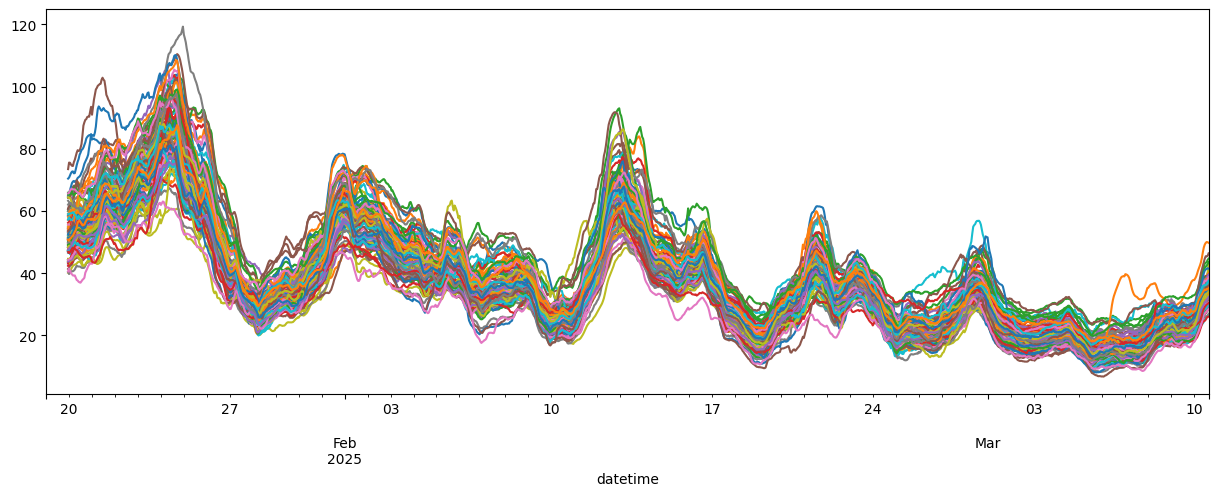

In [17]:
df.rolling(window=24).mean().plot(figsize=(15,5))
plt.legend([], [], frameon=False)

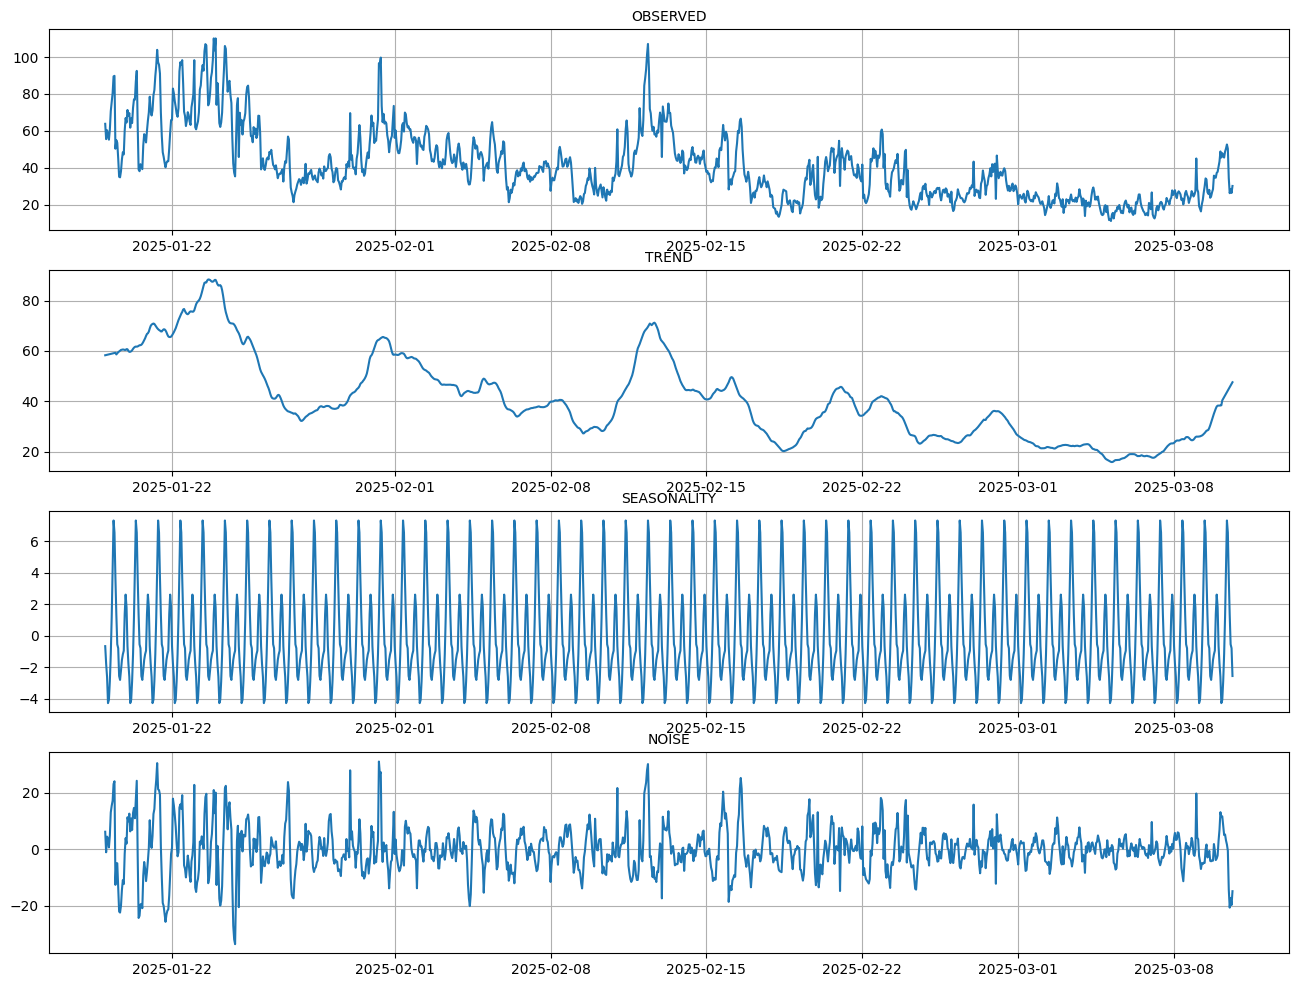

In [18]:
res=sm.tsa.seasonal_decompose(df.iloc[:, 0],model='additive',extrapolate_trend ='freq',period=24)

fig, axs = plt.subplots(4, figsize=(16,12))

axs[0].set_title('OBSERVED', fontsize=10)
axs[0].plot(res.observed)
axs[0].grid()

axs[1].set_title('TREND', fontsize=10)
axs[1].plot(res.trend)
axs[1].grid()

axs[2].set_title('SEASONALITY', fontsize=10)
axs[2].plot(res.seasonal)
axs[2].grid()

axs[3].set_title('NOISE', fontsize=10)
axs[3].plot(res.resid)
axs[3].grid()

plt.legend([], [], frameon=False)
plt.show()

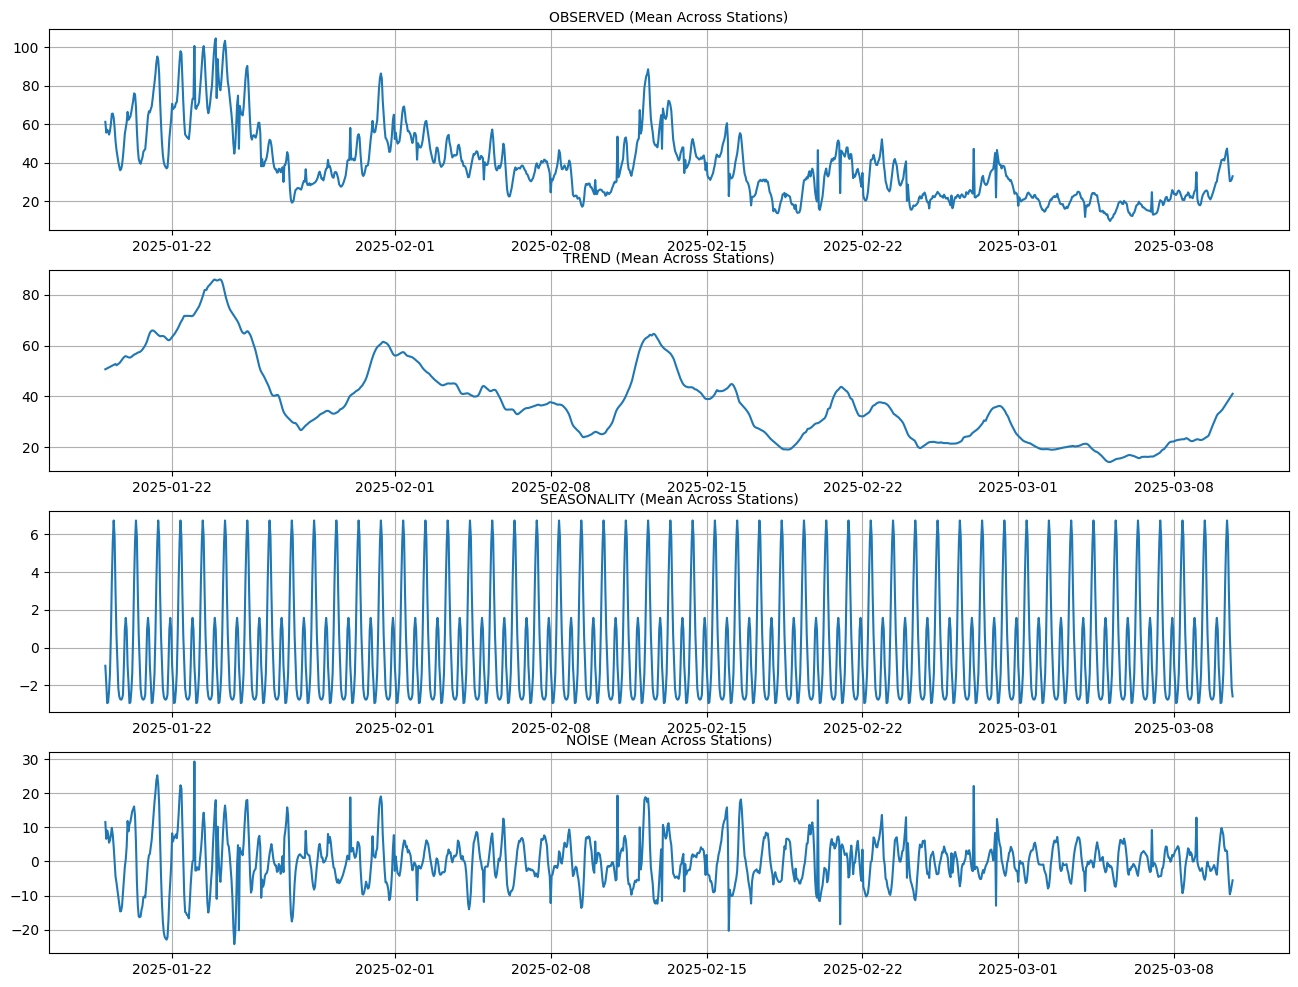

In [19]:
# try aggregrating all stations

period = 24

# Store decomposed components
trends = []
seasonals = []
residuals = []
observed = []

# Loop through all station columns
for station in df.columns:
    res = sm.tsa.seasonal_decompose(df[station], model='additive', extrapolate_trend='freq', period=24)
    
    trends.append(res.trend)
    seasonals.append(res.seasonal)
    residuals.append(res.resid)
    observed.append(res.observed)

# Aggregate results
trends = np.nanmean(np.array(trends), axis=0)
seasonals = np.nanmean(np.array(seasonals), axis=0)
residuals = np.nanmean(np.array(residuals), axis=0)
observed = np.nanmean(np.array(observed), axis=0)


fig, axs = plt.subplots(4, figsize=(16, 12))

axs[0].set_title('OBSERVED (Mean Across Stations)', fontsize=10)
axs[0].plot(df.index, observed)
axs[0].grid()

axs[1].set_title('TREND (Mean Across Stations)', fontsize=10)
axs[1].plot(df.index, trends)
axs[1].grid()

axs[2].set_title('SEASONALITY (Mean Across Stations)', fontsize=10)
axs[2].plot(df.index, seasonals)
axs[2].grid()

axs[3].set_title('NOISE (Mean Across Stations)', fontsize=10)
axs[3].plot(df.index, residuals)
axs[3].grid()

plt.legend([], [], frameon=False)
plt.show()

In [20]:
t = pd.DataFrame({"observed":observed, "trends":trends, "seasonals":seasonals, "residuals":residuals})
t.describe()

,observed,trends,seasonals,residuals
count,1216.000000,1216.000000,1216.000000,1216.000000
mean,38.092042,38.073522,0.006665,0.011854
std,18.239620,16.300340,2.939596,6.833844
min,9.597826,14.179416,-2.931765,-24.261560
25%,23.262500,24.195621,-2.487436,-3.822776
50%,35.535915,35.467572,-0.954262,-0.343742
75%,47.179891,46.068031,1.575140,3.910371
max,104.697826,85.967251,6.723532,29.307794


### Seasonality Interpretation

- The mean of the observed and trends are very close -> the data is somewhat stable
- There are seasonal trends which are daily patterns (due to how the whole set is 1 month long and there are roughly 30 periods)
- Residuals are prevelant with a STDEV of 6.1 which is great than 2.15 of the seasonality

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

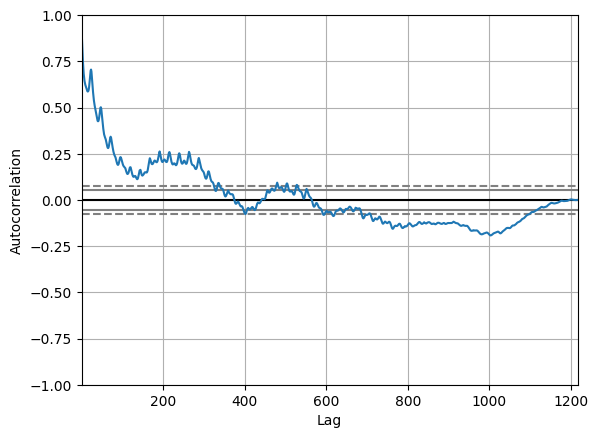

In [21]:
pd.plotting.autocorrelation_plot(df)

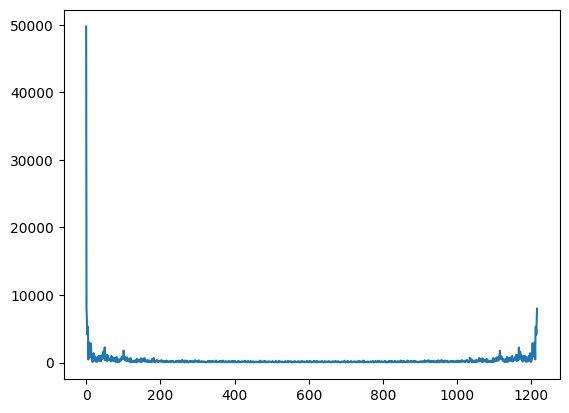

In [22]:
freq_spectrum = np.fft.fft(df.iloc[:, 0].dropna())
plt.plot(np.abs(freq_spectrum))
plt.show()

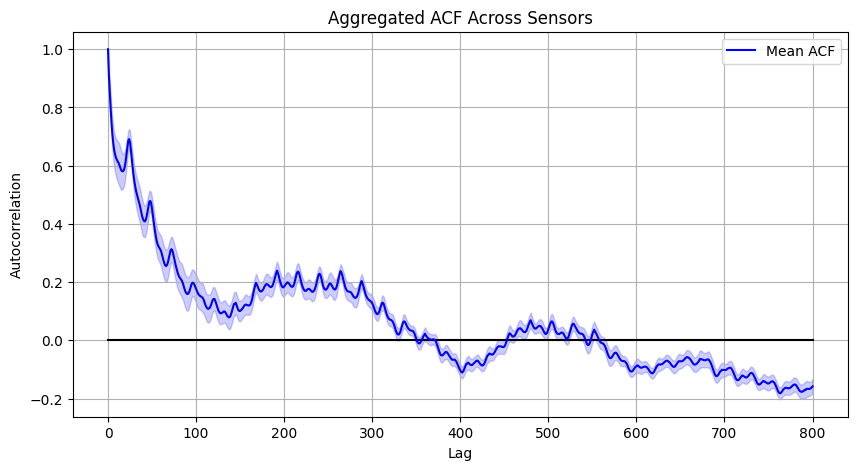

In [23]:
max_lag = 800
acf_values = []

# Compute ACF for each column
for col in df.columns:
    acf_result = sm.tsa.stattools.acf(df[col].dropna(), nlags=max_lag, fft=True)  # ACF
    acf_values.append(acf_result)

# Convert to DataFrame and compute mean across all sensors
acf_matrix = np.array(acf_values)  # Shape: (num_sensors, max_lag+1)
mean_acf = np.mean(acf_matrix, axis=0)
std_acf = np.std(acf_matrix, axis=0)

# Plot the aggregated ACF
plt.figure(figsize=(10, 5))
plt.plot(np.zeros(max_lag+1), color="black") 
plt.plot(range(len(mean_acf)), mean_acf, label="Mean ACF", color='b')
plt.fill_between(range(len(mean_acf)), mean_acf - std_acf, mean_acf + std_acf, color='b', alpha=0.2)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Aggregated ACF Across Sensors")
plt.legend()
plt.grid()
plt.show()


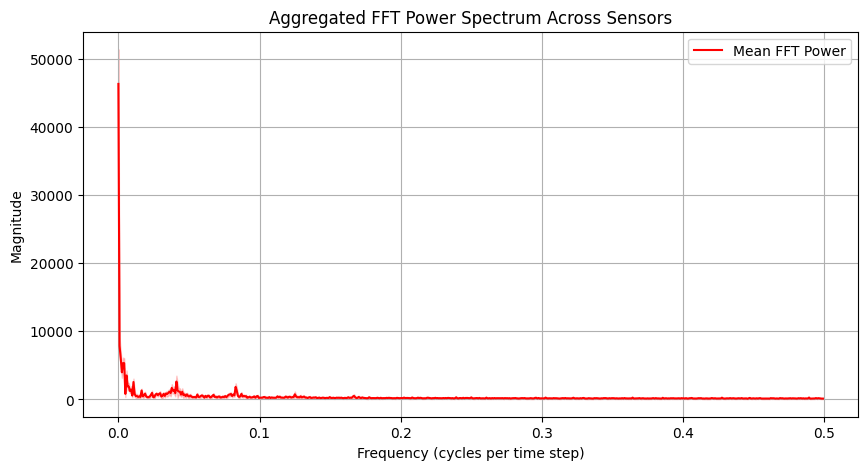

In [24]:
# Define variables
n = len(df)  # Number of time steps
freqs = np.fft.fftfreq(n)  # Frequency axis
fft_values = []

# Compute FFT for each sensor
for col in df.columns:
    fft_result = np.fft.fft(df[col].dropna())
    fft_values.append(np.abs(fft_result))  # Store magnitude of FFT

# Convert to array and compute mean power spectrum
fft_matrix = np.array(fft_values)  # Shape: (num_sensors, n)
mean_fft = np.mean(fft_matrix, axis=0)
std_fft = np.std(fft_matrix, axis=0)

# Plot the aggregated FFT spectrum (Only positive frequencies)
plt.figure(figsize=(10, 5))
plt.plot(freqs[:n//2], mean_fft[:n//2], label="Mean FFT Power", color='r')
plt.fill_between(freqs[:n//2], mean_fft[:n//2] - std_fft[:n//2], mean_fft[:n//2] + std_fft[:n//2], color='r', alpha=0.2)
plt.xlabel("Frequency (cycles per time step)")
plt.ylabel("Magnitude")
plt.title("Aggregated FFT Power Spectrum Across Sensors")
plt.legend()
plt.grid()
plt.show()


### ACF&FFT Interpretation

- There is a large autocorrelation in small lags (To be expected)
- There seems to be some seasonal elements at around 1.1 and 2.5 hour cycle, however, they are very small and are likely neglectible.

## Spatial Analysis

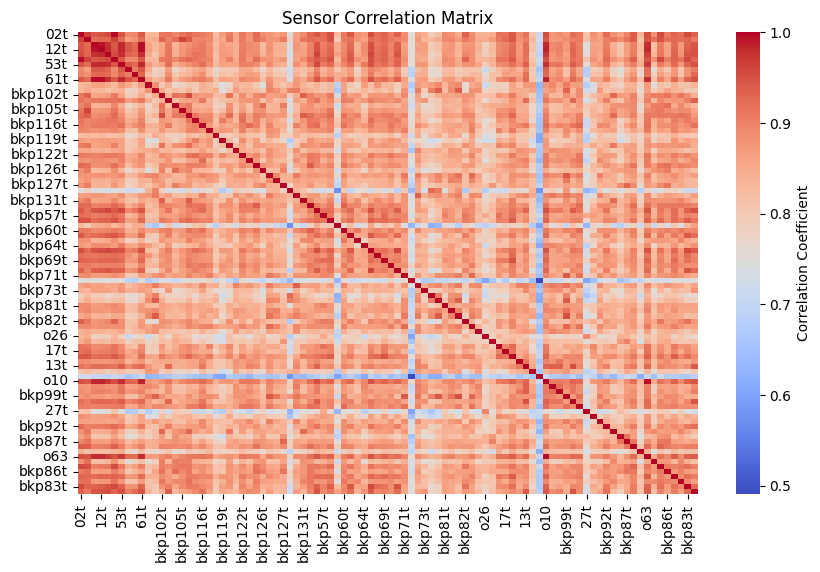

In [25]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Sensor Correlation Matrix")
plt.show()


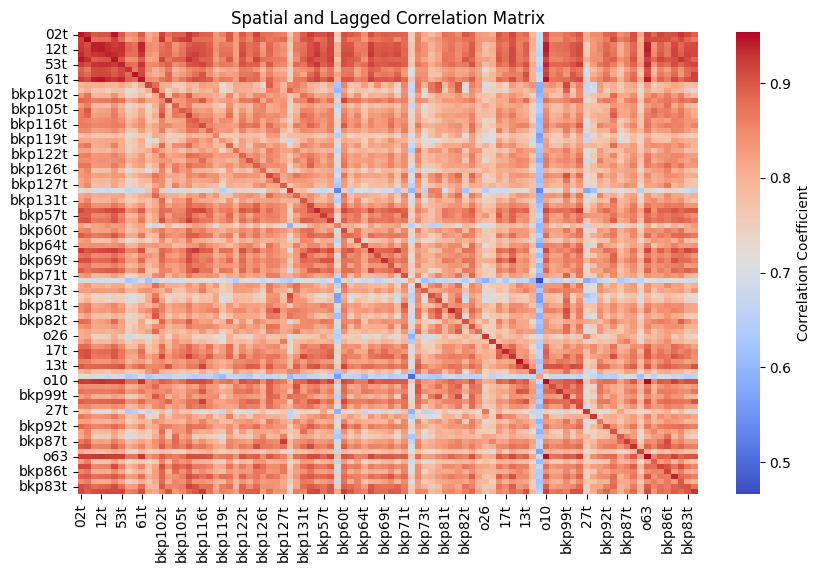

In [26]:
lag = 1

# Shift the data by lag (you can shift by more than 1 if needed)
df_lagged = df.shift(lag)

# Initialize an empty DataFrame to store correlations
lagged_corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate the correlation between original and lagged readings for each pair of stations
for station1 in df.columns:
    for station2 in df.columns:
        # Drop any NaN values from both series (for matching indices)
        corr_value = df[station1].dropna().corr(df_lagged[station2].dropna())
        lagged_corr_matrix.loc[station1, station2] = corr_value

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(lagged_corr_matrix.astype(float), annot=False, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Spatial and Lagged Correlation Matrix")
plt.show()

### Heatmap Interpretation

- There are many stations that shows correlation only with lag 
- This is likely due to it being up or down wind from the other stations
- For example o63 which is in บางนา.

In [27]:
df_geo = pd.read_csv('addr_latlong.csv')
df_geo = df_geo.set_index('sensor_id')
df_geo = df_geo[["latitude", "longitude"]]
df_geo

,latitude,longitude
sensor_id,,
02t,13.732270,100.490197
03t,13.642662,100.409519
11t,13.776413,100.572275
12t,13.707317,100.547104
50t,13.732501,100.536086
...,...,...
bkp86t,13.781345,100.426387
bkp94t,13.708162,100.583706
bkp84t,13.729275,100.473354


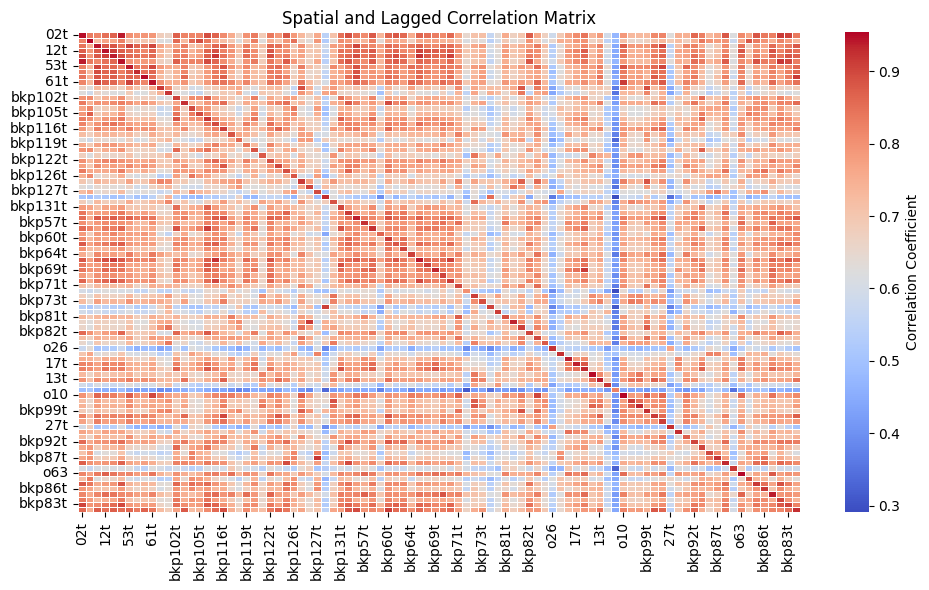

In [28]:
# Compute distance matrix between stations (Euclidean or Haversine)
dist_matrix = pairwise_distances(df_geo[['latitude', 'longitude']])

# Compute the correlation matrix between stations considering lagged data
lagged_corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

for station1 in df.columns:
    for station2 in df.columns:
        # Get the lagged correlation for each station pair
        corr_value = pearsonr(df.iloc[1:][station1], df_lagged.iloc[1:][station2])[0]
        lagged_corr_matrix.loc[station1, station2] = corr_value

# Optionally weight the correlation by distance
# Normalize distance to weight inversely (closer stations get higher weight)
normalized_dist_matrix = 1 / (1 + dist_matrix)  # Example weight (inverse of distance)

# Optionally combine this with your lagged correlation matrix, e.g., by multiplying
weighted_corr_matrix = lagged_corr_matrix * normalized_dist_matrix
weighted_corr_matrix = weighted_corr_matrix.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10,6))
sns.heatmap(weighted_corr_matrix.astype(float), annot=False, cmap="coolwarm", fmt=".2f", 
            cbar_kws={'label': 'Correlation Coefficient'},
            linewidths=0.5,
            cbar=True)

plt.title("Spatial and Lagged Correlation Matrix")
plt.tight_layout()
plt.show()


## Lag analysis

### lag correlation matrix

In [33]:
def calculate_lag(station_a, station_b, max_lag=24):
    ccs = [station_a.corr(station_b.shift(lag)) for lag in range(-max_lag, max_lag+1)]
    max_corr = np.nanmax(ccs)
    optimal_lag = np.argmax(ccs) - max_lag
    return optimal_lag, max_corr

In [34]:
def lag_analysis(df,df_geo):
    stations = df.columns
    lag_matrix = pd.DataFrame(index=stations, columns=stations, dtype=float)

    for s1 in stations:
        for s2 in stations:
            if s1 != s2:
                lag, _ = calculate_lag(df[s1], df[s2])
                lag_matrix.loc[s1, s2] = lag
            else:
                lag_matrix.loc[s1, s2] = 0

    mean_lags = lag_matrix.mean(axis=1)

    # Sort stations by mean lag
    whistle_blowers = mean_lags.sort_values()

    # Heatmap of lag matrix
    plt.figure(figsize=(15,12))
    sns.heatmap(lag_matrix.astype(float), cmap="coolwarm", center=0, annot=False)
    plt.title("Lag Matrix Heatmap")
    plt.xlabel("Station")
    plt.ylabel("Station")
    plt.show()

    # Bar plot of mean lags
    plt.figure(figsize=(15,7))
    whistle_blowers.plot(kind='bar', color='skyblue')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title('Stations Ranked by Average Lag (negative = whistle blower)')
    plt.ylabel('Average Lag')
    plt.xlabel('Stations')
    plt.show()

    df_geo2 = df_geo.copy()
    df_geo2['mean_lag'] = mean_lags

    # Plot stations geographically with color indicating lag
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(df_geo2['longitude'], df_geo2['latitude'], c=df_geo2['mean_lag'],
                    cmap='coolwarm', s=100, edgecolors='k')
    plt.colorbar(sc, label='Average Lag (negative=early, positive=late)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Geographic Visualization of Stations with Average Lag')
    plt.grid(True)
    plt.show()


In [35]:
# Slightly modified lag_analysis to return whistle blowers directly
def lag_analysis_simple(df):
    stations = df.columns
    lag_matrix = pd.DataFrame(index=stations, columns=stations, dtype=float)

    for s1 in stations:
        for s2 in stations:
            if s1 != s2:
                lag, _ = calculate_lag(df[s1], df[s2])
                lag_matrix.loc[s1, s2] = lag
            else:
                lag_matrix.loc[s1, s2] = 0

    mean_lags = lag_matrix.mean(axis=1)
    whistle_blowers = mean_lags.sort_values()
    
    return whistle_blowers

# Rolling window cross-validation
def rolling_window_whistle_blowers(df, df_geo, window_size=300, step_size=150):
    results = []

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window_df = df.iloc[start:end]
        
        whistle_blowers = lag_analysis_simple(window_df)
        results.append(whistle_blowers.index[:5].tolist())  # Top 5 whistle blower stations
    
    results_df = pd.DataFrame(results, 
                              columns=[f'Whistle_{i+1}' for i in range(5)],
                              index=[f'Window_{i+1}' for i in range(len(results))])

    print("Top 5 whistle blower stations across windows:")
    print(results_df)
    
    # Count occurrences of each station in the top-5
    whistle_counts = pd.Series(results_df.values.flatten()).value_counts()

    plt.figure(figsize=(12,6))
    sns.barplot(x=whistle_counts.index, y=whistle_counts.values, palette="viridis")
    plt.title("Consistency of Whistle Blower Stations Across Windows")
    plt.xlabel("Station")
    plt.ylabel("Count in Top-5 Whistle Blowers")
    plt.xticks(rotation=45)
    plt.show()

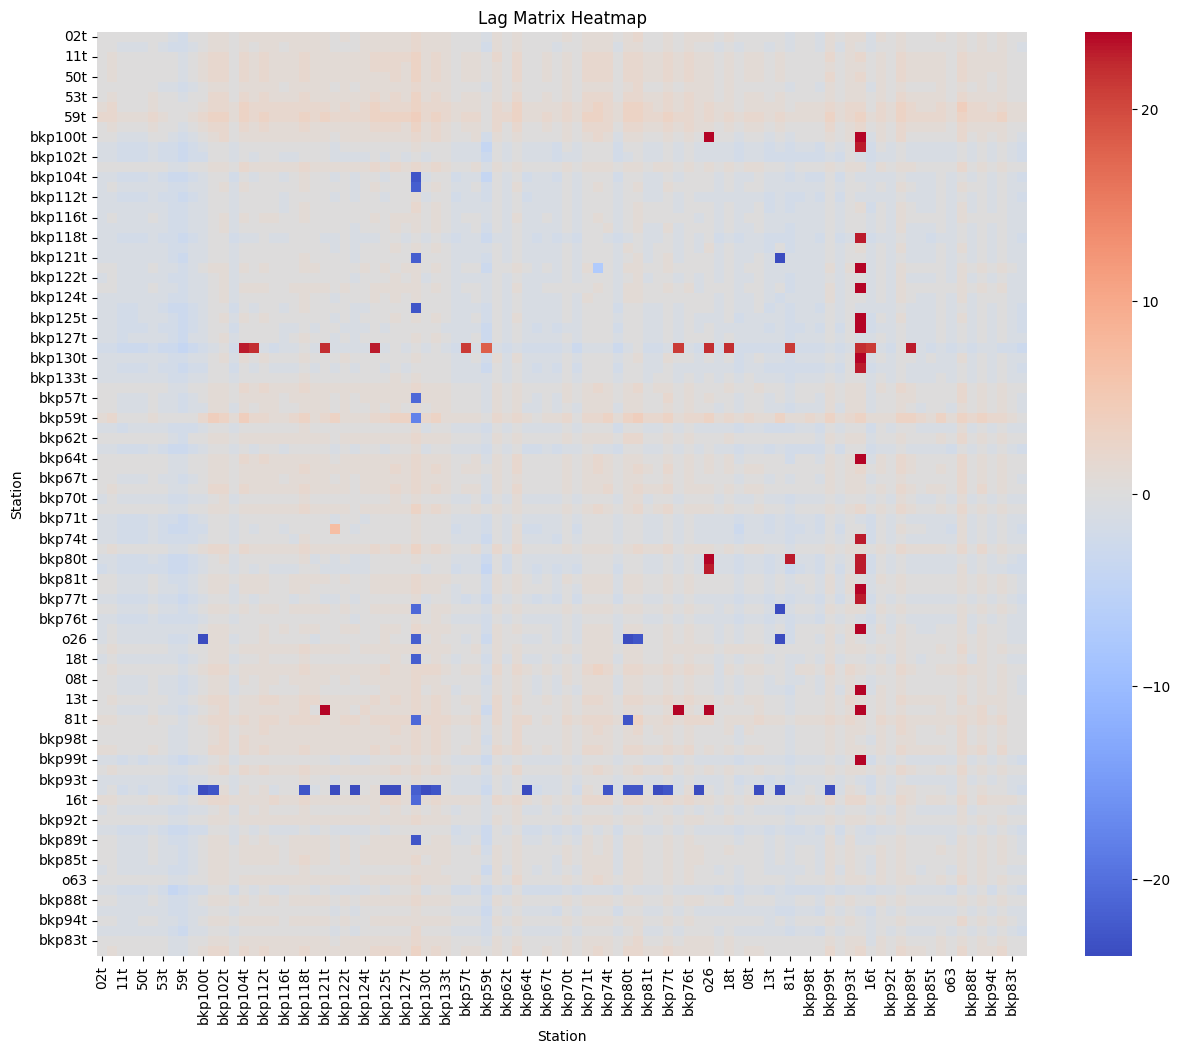

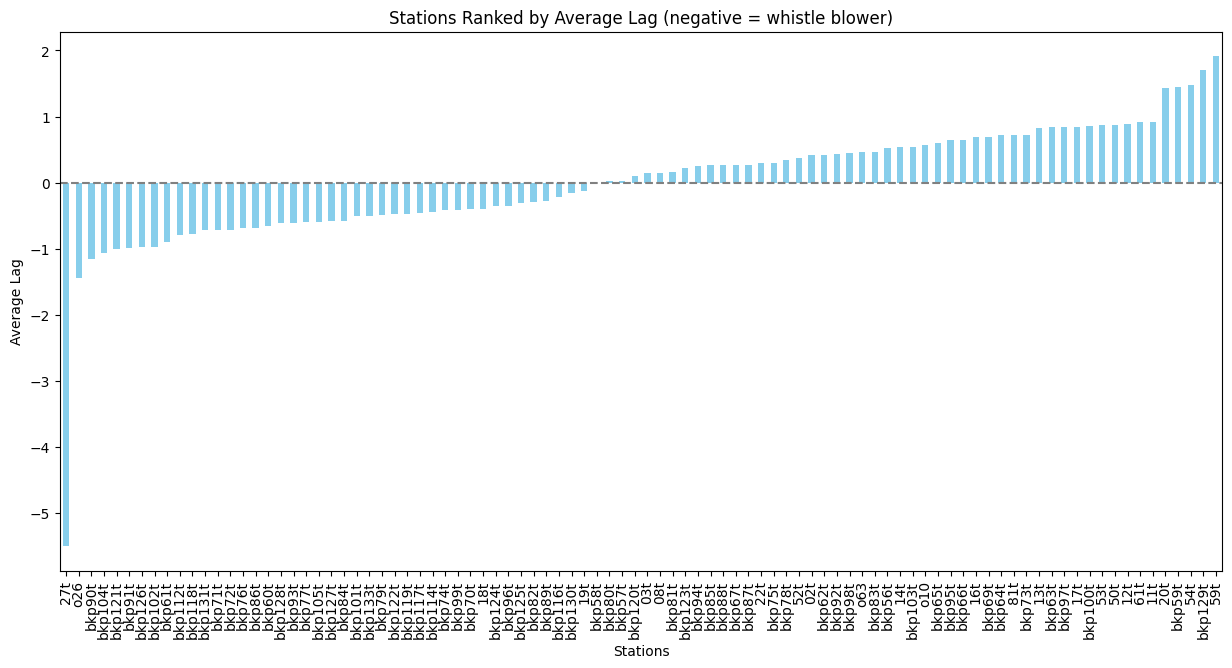

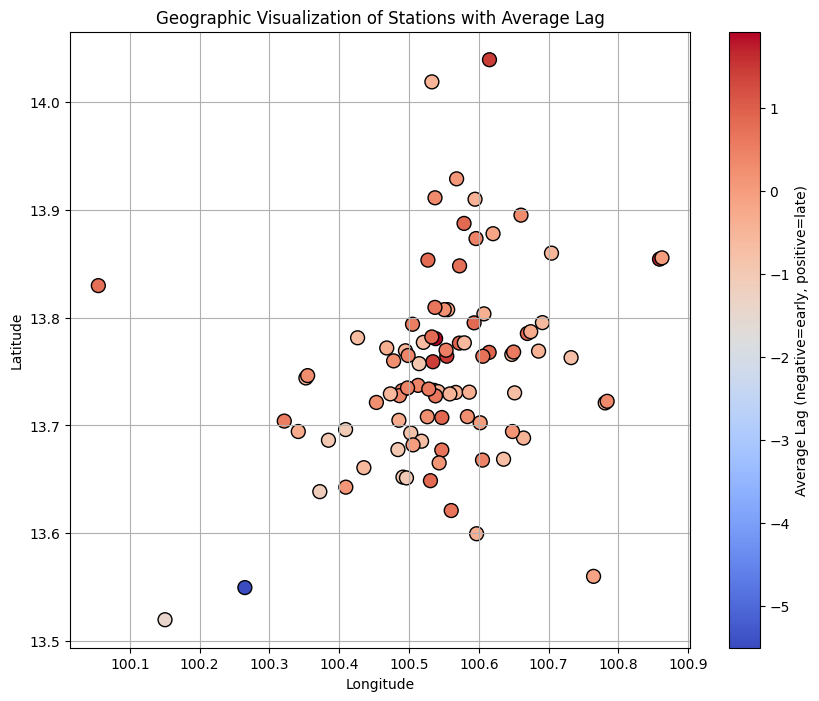

In [28]:
lag_analysis(df,df_geo)

Top 5 whistle blower stations across windows:
         Whistle_1 Whistle_2 Whistle_3 Whistle_4 Whistle_5
Window_1       27t       o26       81t   bkp126t   bkp105t
Window_2       o26       27t       81t   bkp126t   bkp104t
Window_3       27t   bkp128t       o26   bkp131t    bkp72t
Window_4       27t       o26    bkp90t   bkp126t   bkp102t
Window_5       o26   bkp129t    bkp61t    bkp90t   bkp131t
Window_6   bkp129t   bkp128t    bkp79t   bkp118t    bkp61t
Window_7       27t       o26       19t   bkp121t   bkp128t


/tmp/ipykernel_4839/4059006853.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=whistle_counts.index, y=whistle_counts.values, palette="viridis")


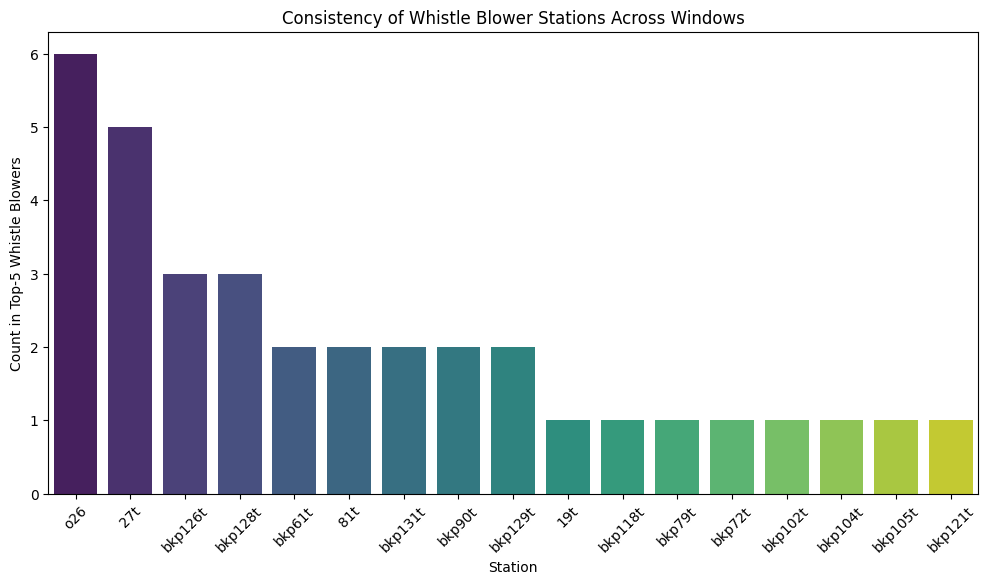

In [29]:
rolling_window_whistle_blowers(df,df_geo,300,150)

In [30]:
df_geo.loc[[val for val in df_geo.index if val in ['27t','o26','59t','bkp129t']]]

,latitude,longitude
sensor_id,,
59t,13.780563,100.538167
bkp129t,13.854355,100.858992
o26,13.519591,100.150465
27t,13.549426,100.264868


### Try splitting the dataframe into chunks of increasing/decreasing trend

In [29]:
def decompose_trend(df, period=24):
    """
    Perform seasonal decomposition to extract trend component for each station.

    Parameters:
    - df (DataFrame): Original time-series data.
    - period (int): Seasonal period (24 for hourly data with daily cycles).

    Returns:
    - df_trend (DataFrame): Trend component for each station.
    """
    trends_df = pd.DataFrame(index=df.index)
    for col in df.columns:
        decomposition = sm.tsa.seasonal_decompose(df[col], model='additive', period=period, extrapolate_trend='freq')
        trends_df[col] = decomposition.trend
    trends_df.dropna(inplace=True)
    return trends_df

def smooth_trend(df_trend, window=6):
    """
    Smooth the trend data using rolling average to mitigate short-term noise.

    Parameters:
    - df_trend (DataFrame): Trend dataframe from decomposition.
    - window (int): Rolling window size in hours.

    Returns:
    - df_smoothed (DataFrame): Smoothed trend data.
    """
    return df_trend.rolling(window=window, min_periods=1, center=True).mean()

def chunk_trend(df_smoothed, min_chunk_length=6):
    """
    Chunk the smoothed trend into increasing/decreasing periods.

    Parameters:
    - df_smoothed (DataFrame): Smoothed trend dataframe.
    - min_chunk_length (int): Minimum length (in hours) for a chunk to be considered valid.

    Returns:
    - chunks (list): List of dictionaries containing chunk details.
    """
    mean_trend = df_smoothed.mean(axis=1)
    trend_diff = mean_trend.diff()
    trend_sign = np.sign(trend_diff).fillna(0)

    chunks = []
    current_sign = trend_sign.iloc[0]
    start_idx = df_smoothed.index[0]

    for time, sign in trend_sign.items():
        if sign != current_sign and sign != 0:
            end_idx = time
            chunk_length = (end_idx - start_idx).total_seconds() / 3600
            if chunk_length >= min_chunk_length:
                chunks.append({
                    'trend_sign': 'increasing' if current_sign > 0 else 'decreasing' if current_sign < 0 else 'stable',
                    'start': start_idx,
                    'end': end_idx,
                    'data': df_smoothed[start_idx:end_idx]
                })
            start_idx = end_idx
            current_sign = sign

    # Add the last chunk
    chunk_length = (df_smoothed.index[-1] - start_idx).total_seconds() / 3600
    if chunk_length >= min_chunk_length:
        chunks.append({
            'trend_sign': 'increasing' if current_sign > 0 else 'decreasing' if current_sign < 0 else 'stable',
            'start': start_idx,
            'end': df_smoothed.index[-1],
            'data': df_smoothed[start_idx:]
        })

    return chunks

def calculate_lag(station_a, station_b, max_lag=24):
    ccs = [station_a.corr(station_b.shift(lag)) for lag in range(-max_lag, max_lag+1)]
    optimal_lag = np.argmax(ccs) - max_lag
    return optimal_lag

def whistleblower_analysis(df_chunk, max_lag=24):
    """
    Perform whistleblower analysis on a chunk of data.

    Parameters:
    - df_chunk (DataFrame): Dataframe representing one chunk.

    Returns:
    - Series: Stations ranked by their whistleblower score.
    """
    stations = df_chunk.columns
    lag_matrix = pd.DataFrame(index=stations, columns=stations, dtype=float)

    for s1 in stations:
        for s2 in stations:
            if s1 != s2:
                lag_matrix.loc[s1, s2] = calculate_lag(df_chunk[s1], df_chunk[s2], max_lag=max_lag)
            else:
                lag_matrix.loc[s1, s2] = 0

    mean_lags = lag_matrix.mean(axis=1)
    return mean_lags.sort_values()


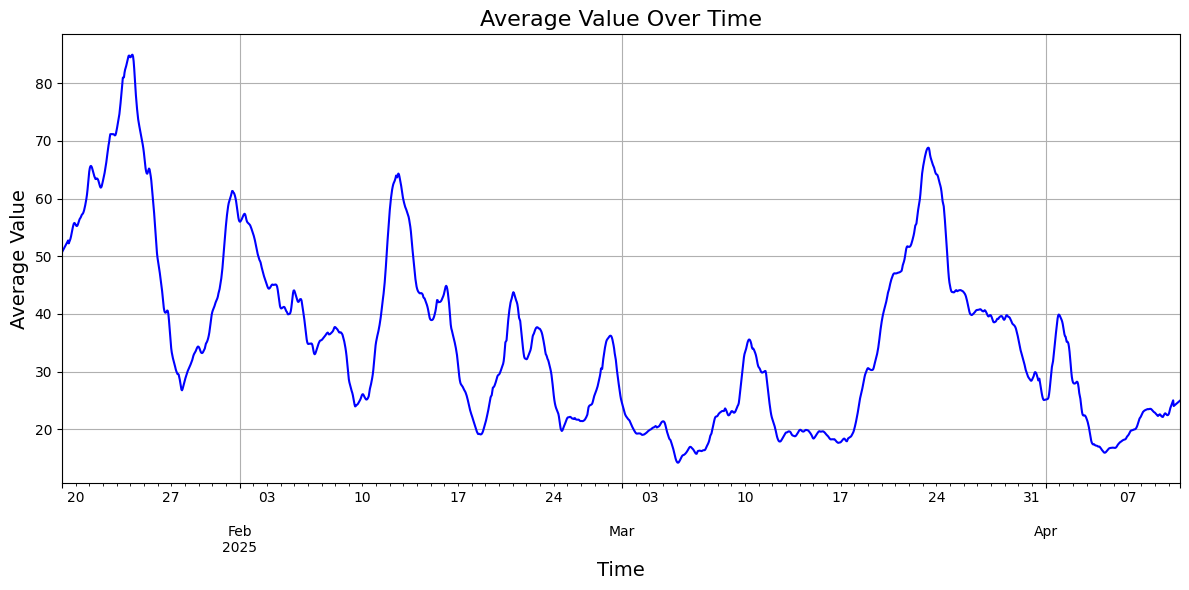

In [50]:
df_trend = decompose_trend(df)
plot_average_over_time(df_trend)

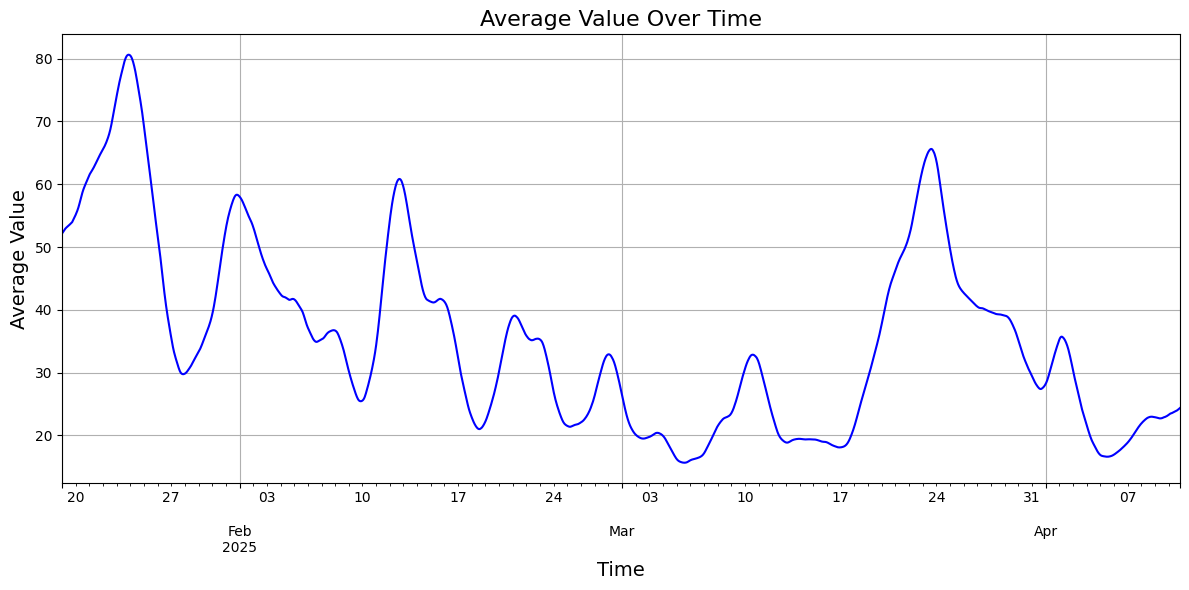

In [58]:
# higher window => smootehr trend
df_smoothed = smooth_trend(df_trend, window=36)
plot_average_over_time(df_smoothed)

In [59]:
df_smoothed.index = pd.to_datetime(df_smoothed.index)
chunks = chunk_trend(df_smoothed, min_chunk_length=12)
print(f"Number of chunks: {len(chunks)}")

Number of chunks: 29


In [60]:
wb_rankings = []
for idx, chunk in enumerate(chunks):
    wb_ranking = whistleblower_analysis(chunk['data'],max_lag=24)
    wb_rankings.append(wb_ranking)
    print(f"Chunk {idx} ({chunk['trend_sign']} from {chunk['start']} to {chunk['end']}):")
    print(wb_ranking.head())  # shows top 5 whistleblower stations

Chunk 0 (increasing from 2025-01-19 01:00:00 to 2025-01-23 22:00:00):
bkp126t   -8.782609
bkp131t   -7.728261
bkp121t   -6.880435
bkp69t    -6.467391
59t       -6.271739
dtype: float64
Chunk 1 (decreasing from 2025-01-23 22:00:00 to 2025-01-27 22:00:00):
bkp81t   -21.217391
81t      -21.086957
o26      -18.543478
22t      -18.413043
27t      -18.163043
dtype: float64
Chunk 2 (increasing from 2025-01-27 22:00:00 to 2025-01-31 20:00:00):
o26       -23.228261
27t       -21.445652
bkp128t   -18.815217
bkp80t    -13.369565
81t       -12.173913
dtype: float64
Chunk 3 (decreasing from 2025-01-31 20:00:00 to 2025-02-04 17:00:00):
19t      -17.347826
bkp72t   -15.836957
bkp82t   -15.630435
27t      -15.217391
bkp59t   -15.010870
dtype: float64
Chunk 4 (decreasing from 2025-02-04 22:00:00 to 2025-02-06 16:00:00):
20t       -21.782609
bkp129t   -21.413043
bkp80t    -20.608696
bkp64t    -20.478261
bkp97t    -19.945652
dtype: float64
Chunk 5 (increasing from 2025-02-06 16:00:00 to 2025-02-07 22:00:

/home/gems/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/gems/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Chunk 9 (increasing from 2025-02-15 06:00:00 to 2025-02-15 18:00:00):
02t   -23.73913
13t   -23.73913
22t   -23.73913
08t   -23.73913
17t   -23.73913
dtype: float64
Chunk 10 (decreasing from 2025-02-15 18:00:00 to 2025-02-18 14:00:00):
bkp64t   -7.836957
bkp89t   -6.706522
27t      -4.347826
bkp61t   -4.315217
bkp72t   -4.097826
dtype: float64
Chunk 11 (increasing from 2025-02-18 14:00:00 to 2025-02-21 04:00:00):
16t       -13.021739
bkp117t   -11.739130
bkp128t   -11.402174
bkp57t    -11.195652
bkp81t     -7.510870
dtype: float64
Chunk 12 (decreasing from 2025-02-21 04:00:00 to 2025-02-22 11:00:00):
16t       -18.119565
18t       -15.771739
bkp121t   -15.739130
bkp57t    -12.847826
19t       -10.086957
dtype: float64
Chunk 13 (decreasing from 2025-02-22 21:00:00 to 2025-02-25 06:00:00):
16t      -7.717391
bkp56t   -6.184783
bkp64t   -5.478261
bkp72t   -5.413043
bkp89t   -3.880435
dtype: float64
Chunk 14 (increasing from 2025-02-25 06:00:00 to 2025-02-28 02:00:00):
bkp128t   -20.141304

/home/gems/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/gems/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Chunk 20 (increasing from 2025-03-13 03:00:00 to 2025-03-14 00:00:00):
02t   -23.73913
13t   -23.73913
22t   -23.73913
08t   -23.73913
17t   -23.73913
dtype: float64
Chunk 21 (decreasing from 2025-03-15 01:00:00 to 2025-03-16 23:00:00):
13t       -14.521739
bkp73t    -14.141304
bkp125t   -13.543478
bkp118t   -12.880435
19t       -12.130435
dtype: float64
Chunk 22 (increasing from 2025-03-16 23:00:00 to 2025-03-23 16:00:00):
19t       -22.260870
bkp57t    -12.750000
bkp128t   -11.728261
bkp67t    -10.836957
o26       -10.032609
dtype: float64
Chunk 23 (decreasing from 2025-03-23 16:00:00 to 2025-03-31 16:00:00):
bkp91t    -19.869565
bkp121t   -11.684783
bkp65t     -7.434783
o26        -6.771739
bkp126t    -5.836957
dtype: float64
Chunk 24 (increasing from 2025-03-31 16:00:00 to 2025-04-02 05:00:00):
bkp89t    -6.184783
bkp84t    -5.097826
bkp87t    -4.641304
bkp126t   -4.489130
bkp60t    -4.478261
dtype: float64
Chunk 25 (decreasing from 2025-04-02 05:00:00 to 2025-04-05 13:00:00):
bkp7

/home/gems/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/gems/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Chunk 27 (decreasing from 2025-04-08 19:00:00 to 2025-04-09 10:00:00):
02t   -23.73913
13t   -23.73913
22t   -23.73913
08t   -23.73913
17t   -23.73913
dtype: float64
Chunk 28 (increasing from 2025-04-09 10:00:00 to 2025-04-10 20:00:00):
bkp87t    -15.173913
bkp58t    -14.456522
bkp82t    -13.717391
bkp126t   -13.467391
bkp95t    -13.260870
dtype: float64


In [61]:
inc_ranks = []
dec_ranks = []
for chunk, rank in zip(chunks,wb_rankings):
    if chunk["trend_sign"] == "increasing":
        inc_ranks.append(rank)
    else:
        dec_ranks.append(rank)
len(inc_ranks), len(dec_ranks)

(14, 15)

In [81]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth specified in decimal degrees.
    
    Parameters:
    - lat1, lon1: Latitude and Longitude of the first point (center of the city).
    - lat2, lon2: Latitude and Longitude of the second point (station).
    
    Returns:
    - Distance in kilometers between the two points.
    """
    # Radius of Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Calculate the distance
    distance = R * c
    return distance

def calculate_distance_to_center(row, city_lat=13.7563, city_lon=100.5018):
    """
    Given a row with latitude and longitude of a station, calculate the distance to the city center.
    
    Parameters:
    - row: A pandas row containing the latitude and longitude of the station.
    - city_lat: Latitude of the city center (default set to Bangkok's latitude).
    - city_lon: Longitude of the city center (default set to Bangkok's longitude).
    
    Returns:
    - Distance in kilometers from the city center to the station.
    """
    return haversine_distance(city_lat, city_lon, row['latitude'], row['longitude'])


def analyze_whistleblower_stations(wb_rankings, df_geo, latitude_threshold=0.9, longitude_threshold=0.9, 
                                    threshold_percent=0.1, distance_func=None, max_lag=24):
    """
    Analyze and compare the whistleblower rankings with geographical data to test the hypothesis 
    that border stations are more likely to be whistle blowers.
    
    Parameters:
    - wb_rankings (list): List of Pandas Series where each series contains the ranked whistleblower stations
    - df_geo (DataFrame): DataFrame with station IDs and their geographical information (latitude, longitude)
    - latitude_threshold (float): Quantile for identifying the border stations based on latitude
    - longitude_threshold (float): Quantile for identifying the border stations based on longitude
    - threshold_percent (float): The expected proportion of stations at the border (used in chi-square test)
    - distance_func (function): Optional function to calculate distance between stations and city center
    - max_lag (int): The maximum lag to be used in the whistleblower analysis
    
    Returns:
    - dict: A dictionary containing the results of the Chi-square test and Spearman's rank correlation
    """
    # Step 1: Identify border stations based on latitude and longitude thresholds
    latitude_threshold_value = df_geo['latitude'].quantile(latitude_threshold)
    longitude_threshold_value = df_geo['longitude'].quantile(longitude_threshold)

    border_stations = df_geo[(df_geo['latitude'] > latitude_threshold_value) | 
                             (df_geo['longitude'] > longitude_threshold_value)]
    border_station_ids = border_stations.index

    # Step 2: Aggregate rankings from all chunks and identify border whistleblower stations
    border_whistleblowers = []
    valid_rankings = []  # To store valid rankings (those with non-constant values)
    
    for wb_ranking in wb_rankings:
        # Check if there is variation in the rankings for the chunk
        if wb_ranking.nunique() > 1:  # At least 2 unique values are required for meaningful correlation
            border_whistleblowers.append(wb_ranking[wb_ranking.index.isin(border_station_ids)])
            valid_rankings.append(wb_ranking)
        else:
            print(f"Skipping Chunk due to constant rankings: {wb_ranking.name}")
    
    # Step 3: Chi-square test
    observed = [len(border_whistleblowers), len(wb_rankings) - len(border_whistleblowers)]
    expected = [len(wb_rankings) * threshold_percent, len(wb_rankings) * (1 - threshold_percent)]
    chi2, p_val = stats.chisquare(observed, expected)

    # Step 4: Spearman's rank correlation (if a distance function is provided)
    spearman_correlations = []
    for ranking in valid_rankings:  # Only use valid rankings for correlation
        # Calculate rank correlation for each chunk separately
        spearman_corr, _ = spearmanr(df_geo['distance'], ranking.values)
        spearman_correlations.append(spearman_corr)

    # You can then aggregate these results (e.g., taking the mean correlation)
    mean_spearman_corr = np.mean(spearman_correlations) if spearman_correlations else None

    # Return results as a dictionary
    results = {
        'chi_square_p_value': p_val,
        'spearman_corr': mean_spearman_corr,
        'border_whistleblowers': border_whistleblowers
    }

    return results



In [82]:
df_geo['distance'] = df_geo.apply(calculate_distance_to_center, axis=1)
obj = analyze_whistleblower_stations(wb_rankings,
                                     df_geo=df_geo,
                                     distance_func=calculate_distance_to_center)
print(f"Chi Square p value: {obj['chi_square_p_value']}\nSpearman Correlation: {obj['spearman_corr']}")

Skipping Chunk due to constant rankings: None
Skipping Chunk due to constant rankings: None
Skipping Chunk due to constant rankings: None
Chi Square p value: 2.2344490543100366e-46
Spearman Correlation: 0.17637481848834022


Extremely low p-value -> the edge stations appear differently in the rankings than normal ones

Spearman = 0.176 -> some correlation between distance and ranking

### VAR+DTW

In [1]:
# def pure_var_analysis(df, lag_order=4, irf_periods=12):
#     model = VAR(df)
#     fitted_model = model.fit(lag_order)

#     irf = fitted_model.irf(irf_periods).orth_irfs
#     influence = np.sum(np.abs(irf), axis=(0, 1))

#     influence_series = pd.Series(influence, index=df.columns).sort_values(ascending=False)

#     influence_series.plot(kind='bar', figsize=(12, 6), title='Pure VAR Station Influence')
#     plt.xlabel('Stations')
#     plt.ylabel('Aggregate IRF Magnitude')
#     plt.grid(True)
#     plt.show()

#     return influence_series

In [2]:
# def pure_dtw_analysis(df):
#     stations = df.columns
#     lead_counts = pd.Series(0, index=stations, dtype=int)

#     for target_station in stations:
#         for source_station in stations:
#             if source_station != target_station:
#                 distance, paths = dtw.warping_paths_fast(
#                     df[source_station].values, 
#                     df[target_station].values
#                 )
#                 best_path = dtw.best_path(paths)
#                 shifts = [a - b for a, b in best_path]
#                 avg_shift = np.mean(shifts)
#                 if avg_shift < 0:
#                     lead_counts[source_station] += 1

#     lead_counts_sorted = lead_counts.sort_values(ascending=False)

#     lead_counts_sorted.plot(kind='bar', figsize=(12, 6), 
#                             title='Pure DTW Whistle Blower Score')
#     plt.xlabel('Stations')
#     plt.ylabel('Lead Counts')
#     plt.grid(True)
#     plt.show()

#     return lead_counts_sorted


In [3]:
# pure_var_analysis(df,lag_order=3,irf_periods=6)

In [4]:
# pure_dtw_analysis(df)

In [5]:
# def var_dtw_analysis(df, df_geo, lag_order=4, irf_periods=24):

#     # df = df.sort_index()
#     # df = df.asfreq('H')
#     # print(df)

#     # Fit VAR model
#     model = VAR(df)
#     fitted_model = model.fit(lag_order)

#     # Compute impulse responses for all station pairs
#     stations = df.columns
#     num_stations = len(stations)
#     irf_values = {}

#     for i, source_station in enumerate(stations):
#         # Shock at source_station
#         irf = fitted_model.irf(irf_periods).irfs[:, :, i]
#         irf_values[source_station] = pd.DataFrame(irf, columns=stations)

#     # Compute DTW distances and directionality
#     lead_counts = pd.Series(0, index=stations, dtype=int)

#     for target_station in stations:
#         for source_station in stations:
#             if source_station != target_station:
#                 # DTW alignment between source impulse (on target) and target's impulse (on itself)
#                 distance, paths = dtw.warping_paths_fast(
#                     irf_values[source_station][target_station].values,
#                     irf_values[target_station][target_station].values,
#                 )
#                 best_path = dtw.best_path(paths)
                
#                 # Check lead/lag from DTW path (negative shift = source leads target)
#                 shifts = [a - b for a, b in best_path]
#                 avg_shift = np.mean(shifts)
                
#                 if avg_shift < 0:
#                     lead_counts[source_station] += 1

#     # Identify stations frequently leading others
#     lead_counts_sorted = lead_counts.sort_values(ascending=False)

#     # Plot results
#     plt.figure(figsize=(15,7))
#     sns.barplot(x=lead_counts_sorted.index, y=lead_counts_sorted.values, palette="coolwarm")
#     plt.title('Stations Ranked by VAR+DTW Whistle Blower Score')
#     plt.xlabel('Stations')
#     plt.ylabel('Lead Counts (Higher = More likely Whistle Blower)')
#     plt.xticks(rotation=90)
#     plt.grid(True)
#     plt.show()

#     # Geographic plot
#     df_geo2 = df_geo.copy()
#     df_geo2['lead_count'] = lead_counts

#     plt.figure(figsize=(10,8))
#     sc = plt.scatter(df_geo2['longitude'], df_geo2['latitude'], 
#                      c=df_geo2['lead_count'], cmap='coolwarm', s=100, edgecolors='k')
#     plt.colorbar(sc, label='VAR+DTW Lead Counts (Higher = Early Indicator)')
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.title('Geographic Visualization of Whistle Blower Stations (VAR+DTW)')
#     plt.grid(True)
#     plt.show()

#     return lead_counts_sorted

In [6]:
# var_dtw_analysis(df, df_geo, lag_order=3, irf_periods=6)

### Granger

In [7]:
# def pure_granger_analysis(df, maxlag=4, significance=0.05):
#     stations = df.columns
#     granger_counts = pd.Series(0, index=stations, dtype=int)

#     for caused_station in stations:
#         for causing_station in stations:
#             if causing_station != caused_station:
#                 test_result = grangercausalitytests(
#                     df[[caused_station, causing_station]], maxlag=maxlag)
#                 p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(maxlag)]
#                 if np.min(p_values) < significance:
#                     granger_counts[causing_station] += 1

#     granger_counts_sorted = granger_counts.sort_values(ascending=False)

#     granger_counts_sorted.plot(kind='bar', figsize=(12, 6),
#                                title='Pure Granger Causality Whistle Blower Score')
#     plt.xlabel('Stations')
#     plt.ylabel('Granger-caused Counts (p<0.05)')
#     plt.grid(True)
#     plt.show()

#     return granger_counts_sorted


In [8]:
# pure_granger_analysis(df,maxlag=3)

### Note: we may have to rank them all and somehow make it one list for analysis

# Preprocessing II

## Normalization

In [33]:
def split_data(df, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Splits the dataframe into train, validation, and test sets based on time indices.
    """
    # assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1"

    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    return train_df, val_df, test_df

def normalize_chunks(df, method=None, chunk_size=10000):
    """
    Normalizes data using a chunk-wise approach to handle large datasets efficiently.
    - Splits the data into train, val, and test (70:20:10).
    - Normalizes in chunks to save memory.
    """
    # Split data
    train_df, val_df, test_df = split_data(df)

    # Determine the normalization method if not provided
    avg_skew = check_skewness(train_df)
    print(f"Train Data Average Skewness: {avg_skew:.2f}")

    if method is None:
        if avg_skew < 0.5:
            method = 'standard'
        elif avg_skew < 2:
            method = 'minmax'
        else:
            method = 'yeo-johnson'
    print(f"Using {method} normalization.")

    # Choose scaler
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif method == 'yeo-johnson':
        scaler = PowerTransformer(method='yeo-johnson')
    else:
        raise ValueError("Invalid normalization method. Choose 'standard', 'minmax', or 'yeo-johnson'.")

    # Normalize in chunks
    def fit_transform_in_chunks(df, fit=True):
        normalized_chunks = []
        for start in range(0, len(df), chunk_size):
            chunk = df.iloc[start:start + chunk_size]
            if fit:
                transformed_chunk = scaler.fit_transform(chunk)
            else:
                transformed_chunk = scaler.transform(chunk)
            normalized_chunks.append(pd.DataFrame(transformed_chunk, columns=df.columns, index=chunk.index))
        return pd.concat(normalized_chunks)

    # Fit only on train data
    train_norm = fit_transform_in_chunks(train_df, fit=True)
    val_norm = fit_transform_in_chunks(val_df, fit=False)
    test_norm = fit_transform_in_chunks(test_df, fit=False)

    norm = pd.concat([train_norm, val_norm, test_norm])

    return norm, scaler  # Return scaler for inverse transformation if needed


In [34]:
norm, scaler = normalize_chunks(df)

Train Data Average Skewness: 1.02
Using minmax normalization.


In [35]:
norm.head()

,02t,03t,11t,12t,50t,52t,53t,54t,59t,61t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-19 01:00:00,0.435367,0.381890,0.446731,0.415025,0.417946,0.424149,0.416290,0.336580,0.438672,0.378882,...,0.476783,0.495370,0.502931,0.435714,0.453942,0.510168,0.351449,0.443097,0.443299,0.405460
2025-01-19 02:00:00,0.485005,0.430118,0.458838,0.463054,0.463991,0.488132,0.479638,0.446970,0.445887,0.457143,...,0.490879,0.381944,0.513482,0.458036,0.422407,0.500442,0.381341,0.466418,0.453608,0.457027
2025-01-19 03:00:00,0.460186,0.444882,0.435835,0.434729,0.479339,0.439628,0.493213,0.357143,0.496392,0.426087,...,0.540630,0.319444,0.423212,0.474107,0.463071,0.631300,0.425725,0.500000,0.422680,0.479272
2025-01-19 04:00:00,0.432265,0.417323,0.364407,0.401478,0.400236,0.430341,0.366516,0.288961,0.558442,0.366460,...,0.605307,0.353009,0.398593,0.463393,0.472199,0.585323,0.375000,0.513060,0.381443,0.471183
2025-01-19 05:00:00,0.489142,0.466535,0.371671,0.418719,0.391972,0.464396,0.361991,0.298701,0.587302,0.378882,...,0.724710,0.438657,0.491208,0.617857,0.496266,0.593280,0.359601,0.665112,0.340206,0.394338


In [36]:
norm.to_csv("scaled_data.csv")

In [37]:
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved successfully as 'scaler.pkl'")

Scaler saved successfully as 'scaler.pkl'


## Trend Removal

In [38]:
def remove_trend(df, window=24):
    """
    Removes trend using a rolling average.
    Returns residuals and the trend.
    """
    trend = df.rolling(window=window, min_periods=1).mean()
    residuals = df - trend  # Subtract trend
    return residuals, trend

In [39]:
residuals, trend = remove_trend(norm)

In [40]:
residuals

,02t,03t,11t,12t,50t,52t,53t,54t,59t,61t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-19 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-01-19 02:00:00,0.024819,0.024114,0.006053,0.024015,0.023022,0.031992,0.031674,0.055195,0.003608,0.039130,...,0.007048,-0.056713,0.005275,0.011161,-0.015768,-0.004863,0.014946,0.011660,0.005155,0.025784
2025-01-19 03:00:00,0.000000,0.025919,-0.011299,-0.002874,0.025580,-0.011008,0.030166,-0.023088,0.036075,0.005383,...,0.037866,-0.079475,-0.056663,0.018155,0.016598,0.083996,0.039553,0.030162,-0.017182,0.032019
2025-01-19 04:00:00,-0.020941,-0.001230,-0.062046,-0.027094,-0.040142,-0.015222,-0.072398,-0.068452,0.073593,-0.040683,...,0.076907,-0.034433,-0.060961,0.005580,0.019295,0.028515,-0.008379,0.032416,-0.043814,0.017947
2025-01-19 05:00:00,0.028749,0.038386,-0.043826,-0.007882,-0.038725,0.015067,-0.061538,-0.046970,0.081962,-0.022609,...,0.157048,0.040972,0.025322,0.128036,0.034689,0.029178,-0.019022,0.147575,-0.068041,-0.047118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10 11:00:00,-0.042787,0.081160,0.081618,0.062962,0.046143,-0.017802,0.058117,0.171402,0.096020,0.120342,...,0.055176,0.036989,0.012114,-0.040290,0.065111,-0.038204,0.031552,-0.071323,0.000430,0.083923
2025-03-10 12:00:00,-0.126293,-0.001681,-0.000252,-0.000975,-0.005510,-0.096319,-0.016450,0.085768,0.043170,0.065010,...,-0.023321,-0.001977,-0.027599,-0.060007,-0.082400,-0.125479,-0.030193,-0.067125,-0.072165,-0.044826
2025-03-10 13:00:00,-0.104662,-0.044701,-0.015688,-0.026324,-0.032468,-0.070390,-0.034832,0.055014,-0.000842,0.026035,...,-0.046089,0.023630,-0.044451,0.015625,-0.046058,-0.072392,-0.030155,-0.080068,-0.044674,-0.030376


In [41]:
trend

,02t,03t,11t,12t,50t,52t,53t,54t,59t,61t,...,bkp85t,19t,o63,bkp90t,bkp88t,bkp86t,bkp94t,bkp84t,bkp83t,bkp63t
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-19 01:00:00,0.435367,0.381890,0.446731,0.415025,0.417946,0.424149,0.416290,0.336580,0.438672,0.378882,...,0.476783,0.495370,0.502931,0.435714,0.453942,0.510168,0.351449,0.443097,0.443299,0.405460
2025-01-19 02:00:00,0.460186,0.406004,0.452785,0.439039,0.440968,0.456140,0.447964,0.391775,0.442280,0.418012,...,0.483831,0.438657,0.508206,0.446875,0.438174,0.505305,0.366395,0.454757,0.448454,0.431244
2025-01-19 03:00:00,0.460186,0.418963,0.447135,0.437603,0.453758,0.450636,0.463047,0.380231,0.460317,0.420704,...,0.502764,0.398920,0.479875,0.455952,0.446473,0.547303,0.386171,0.469838,0.439863,0.447253
2025-01-19 04:00:00,0.453206,0.418553,0.426453,0.428571,0.440378,0.445562,0.438914,0.357413,0.484848,0.407143,...,0.528400,0.387442,0.459555,0.457812,0.452905,0.556808,0.383379,0.480644,0.425258,0.453236
2025-01-19 05:00:00,0.460393,0.428150,0.415496,0.426601,0.430697,0.449329,0.423529,0.345671,0.505339,0.401491,...,0.567662,0.397685,0.465885,0.489821,0.461577,0.564103,0.378623,0.517537,0.408247,0.441456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10 11:00:00,0.258919,0.223958,0.219835,0.243688,0.243113,0.237616,0.236001,0.245265,0.299363,0.181522,...,0.250795,0.188706,0.223525,0.296540,0.208748,0.252174,0.210296,0.286808,0.267612,0.253792
2025-03-10 12:00:00,0.258661,0.227075,0.229066,0.244817,0.246360,0.237702,0.238169,0.252976,0.303151,0.187164,...,0.253835,0.192949,0.228068,0.295722,0.208541,0.252800,0.214070,0.288207,0.268041,0.252107
2025-03-10 13:00:00,0.259781,0.228757,0.237238,0.243073,0.249705,0.240669,0.239583,0.257756,0.305315,0.191356,...,0.256703,0.197434,0.234369,0.301339,0.209544,0.255416,0.215844,0.289956,0.271478,0.255856


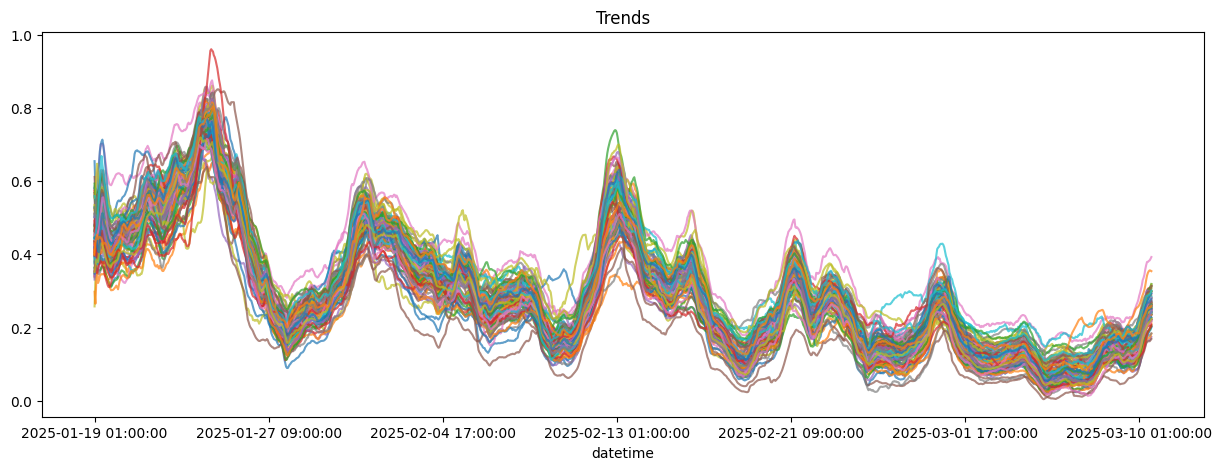

In [43]:
trend.plot(figsize=(15,5), alpha=0.7)
plt.title("Trends")
plt.legend([], [], frameon=False)
plt.show()

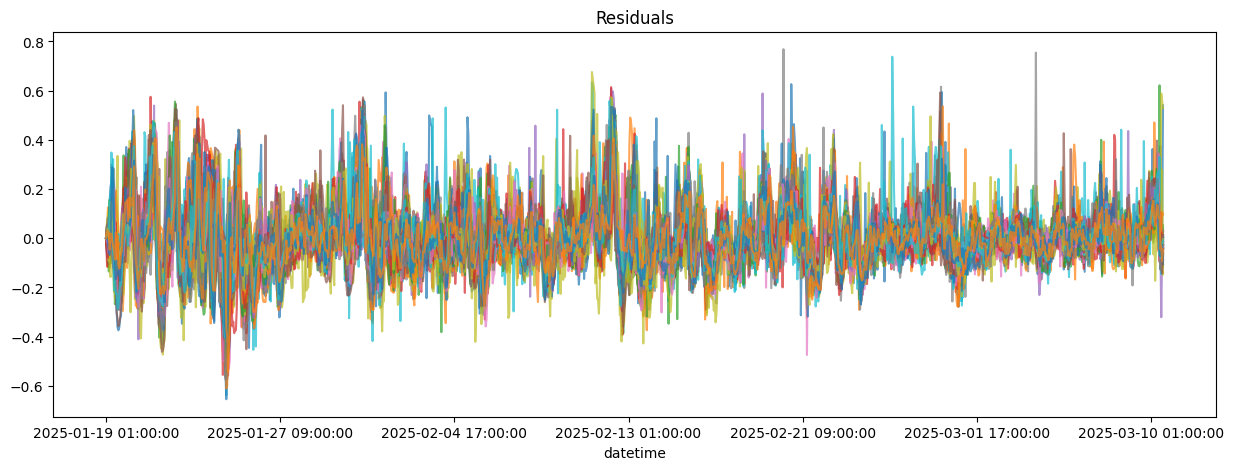

In [44]:
residuals.plot(figsize=(15,5), alpha=0.7)
plt.title("Residuals")
plt.legend([], [], frameon=False)
plt.show()

In [42]:
residuals.to_csv("scaled_residuals.csv")
trend.to_csv("scaled_trend.csv")